# Training

Author: CHEN Ee Heng  
Date: 29.08.2023  

In [77]:
# CONSTANTS + VARIABLES

DATA_PATH = "../data/public_maps.csv"

TRANSLATED_TEXT_PATH = "../data/translated_text_googletrans.csv"

SAVE_PROCESSED_DATA = True
PROCESSED_DATA_PATH = "../data/public_maps_processed.csv"

LABEL_ID_PATH = "../data/label_id.json"

KFOLD = 3
SEED = 1
PCA = 15

MODEL_TRAINING_PATH = "../result/model_training.log"
TRAINING_SUMMARY_PATH = "../result/training_summary.csv"
FT_MODEL_TRAINING_PATH = "../result/ft_model_training.log"
FT_TRAINING_SUMMARY_PATH = "../result/ft_training_summary.csv"

CONFUSIONMATRIX_PATH = "../result/cm_INSERTTITLE.jpg"
LABEL_HISTOGRAM_PATH = "../result/hist_INSERTTITLE.jpg"

FITTED_CLASSIFIER_MODEL_PATH = "../result/classifier.pickle"

In [31]:
import json

with open(LABEL_ID_PATH) as f:
    label_id = {v: k for k, v in json.load(f).items()}
label_id

{0: 'Technology',
 1: 'Education',
 2: 'Life',
 3: 'Other',
 4: 'Business',
 5: 'Entertainment',
 6: 'Productivity'}

## Training data preprocessing

In [2]:
# Data (conversion takes ~33min)

import pandas as pd

df = pd.read_csv(PROCESSED_DATA_PATH,
                 delimiter=",",
                 header=[0],
                 index_col=[0],
                 converters={'map_title_en_tok_bert': pd.eval,
                             'map_title_en_emb_bert': pd.eval,
                             'map_title_tok_bert': pd.eval,
                             'map_title_emb_bert': pd.eval,
                             'map_title_tok_m2m': pd.eval,
                             'map_title_emb_m2m': pd.eval,
                             'idea_title_en_tok_bert': pd.eval,
                             'idea_title_en_emb_bert': pd.eval,
                             'idea_title_tok_bert': pd.eval,
                             'idea_title_emb_bert': pd.eval,
                             'idea_title_tok_m2m': pd.eval,
                             'idea_title_emb_m2m': pd.eval})

df = df.reindex(columns=['map_id',
                         'map_category_id',
                         'map_rating',
                         'map_title_count',
                         'map_title_en_tok_bert',
                         'map_title_en_emb_bert',
                         'map_title_tok_bert',
                         'map_title_emb_bert',
                         'map_title_tok_m2m',
                         'map_title_emb_m2m',
                         'idea_parent_depth',
                         'idea_per_map_count',
                         'idea_title_count',
                         'idea_title_en_tok_bert',
                         'idea_title_en_emb_bert',
                         'idea_title_tok_bert',
                         'idea_title_emb_bert',
                         'idea_title_tok_m2m',
                         'idea_title_emb_m2m',
                         #  'map_category_name',
                         #  'map_title',
                         #  'map_title_en',
                         #  'idea_title',
                         #  'idea_title_en',
                         #  'idea_id',
                         #  'idea_parent_id',
                         ])
df.columns, df.shape

(Index(['map_id', 'map_category_id', 'map_rating', 'map_title_count',
        'map_title_en_tok_bert', 'map_title_en_emb_bert', 'map_title_tok_bert',
        'map_title_emb_bert', 'map_title_tok_m2m', 'map_title_emb_m2m',
        'idea_parent_depth', 'idea_per_map_count', 'idea_title_count',
        'idea_title_en_tok_bert', 'idea_title_en_emb_bert',
        'idea_title_tok_bert', 'idea_title_emb_bert', 'idea_title_tok_m2m',
        'idea_title_emb_m2m'],
       dtype='object'),
 (13466, 19))

In [3]:
# Feature engineering for row merging + experimental purposes

def generate_new_feature(_df, column):
    _df[f'{column}_min'] = _df[f'{column}']
    _df[f'{column}_min'] = _df.groupby('map_id')[f'{column}_min'].transform('min')  # noqa
    _df[f'{column}_max'] = _df[f'{column}']
    _df[f'{column}_max'] = _df.groupby('map_id')[f'{column}_max'].transform('max')  # noqa
    _df[f'{column}_mean'] = _df[f'{column}']
    _df[f'{column}_mean'] = _df.groupby('map_id')[f'{column}_mean'].transform('mean')  # noqa
    return _df


df = generate_new_feature(df, 'idea_parent_depth')
df = generate_new_feature(df, 'idea_title_count')
df['idea_title_count_diff'] = df['idea_title_count_max'] - df['idea_title_count_min']  # noqa


# Pad token length to 512

def pad_to_512(_df, column):
    _df[f'{column}_pad512'] = _df[f'{column}'].apply(
        lambda x: (x + [0] * (512 - len(x)))[:512])
    return _df


for col in list(df):
    if 'tok' in col:
        df = pad_to_512(df, col)

In [4]:
# Hand Crafted textures
df_feat = df.reindex(columns=['map_id',  # (UID)
                              'map_category_id',  # (label)
                              'map_rating',
                              'map_title_count',
                              'idea_per_map_count',
                              'idea_parent_depth_max',
                              'idea_parent_depth_mean',
                              'idea_title_count_min',
                              'idea_title_count_max',
                              'idea_title_count_mean',
                              'idea_title_count_diff',
                              #   'idea_parent_depth',
                              #   'idea_parent_depth_min',
                              #   'idea_title_count',
                              ])
df_feat = df_feat.drop_duplicates().reset_index()

In [5]:
# Text encoding features

def process_emb_cell_list(_df, column, new_feature=False):
    _df[f'{column}_min'] = _df[f'{column}'].apply(lambda x: min(x))
    _df[f'{column}_max'] = _df[f'{column}'].apply(lambda x: max(x))
    _df[f'{column}_mean'] = _df[f'{column}'].apply(lambda x: sum(x)/len(x))
    if new_feature:
        _df = generate_new_feature(_df, f'{column}_min')
        _df = generate_new_feature(_df, f'{column}_max')
        _df = generate_new_feature(_df, f'{column}_mean')
        _df = _df.drop([f'{column}_min', f'{column}_max', f'{column}_mean'],
                       axis=1)
    return _df


def process_tok_cell_list(_df, column, new_feature=False):
    # no min cause min will always just be 0 due to padding
    _df[f'{column}_max'] = _df[f'{column}'].apply(
        lambda x: max([i for i in x if i != 0]))
    _df[f'{column}_mean'] = _df[f'{column}'].apply(
        lambda x: sum([i for i in x if i != 0])/len([i for i in x if i != 0]))
    _df[f'{column}_count'] = _df[f'{column}'].apply(
        lambda x: len([i for i in x if i != 0]))
    if new_feature:
        _df = generate_new_feature(_df, f'{column}_max')
        _df = generate_new_feature(_df, f'{column}_mean')
        _df = generate_new_feature(_df, f'{column}_count')
        _df = _df.drop([f'{column}_max', f'{column}_mean', f'{column}_count'],
                       axis=1)
    return _df


df_text = df.reindex(columns=['map_id',  # (UID)
                              'map_category_id',  # (label)
                              'map_title_en_emb_bert',  # 768d
                              'map_title_emb_bert',  # 768d
                              'map_title_emb_m2m',  # 1024d
                              'map_title_en_tok_bert_pad512',
                              'map_title_tok_bert_pad512',
                              'map_title_tok_m2m_pad512',
                              'idea_title_en_emb_bert',  # 768d
                              'idea_title_emb_bert',  # 768d
                              'idea_title_emb_m2m',  # 1024d
                              'idea_title_en_tok_bert_pad512',
                              'idea_title_tok_bert_pad512',
                              'idea_title_tok_m2m_pad512',
                              #    'map_title_en_tok_bert',
                              #    'map_title_tok_bert',
                              #    'map_title_tok_m2m',
                              #    'idea_title_en_tok_bert',
                              #    'idea_title_tok_bert',
                              #    'idea_title_tok_m2m',
                              ])

for col in [
    'map_title_en_emb_bert',  # 768d
    'map_title_emb_bert',  # 768d
    'map_title_emb_m2m',  # 1024d
    'idea_title_en_emb_bert',  # 768d
    'idea_title_emb_bert',  # 768d
    'idea_title_emb_m2m',  # 1024d
]:
    df_text = process_emb_cell_list(
        df_text, col, True if 'idea' in col else False)
    df_text = df_text.drop([col], axis=1)

for col in [
    'map_title_en_tok_bert_pad512',
    'map_title_tok_bert_pad512',
    'map_title_tok_m2m_pad512',
    'idea_title_en_tok_bert_pad512',
    'idea_title_tok_bert_pad512',
    'idea_title_tok_m2m_pad512',
]:
    df_text = process_tok_cell_list(
        df_text, col, True if 'idea' in col else False)
    df_text = df_text.drop([col], axis=1)

df_text = df_text.drop_duplicates().reset_index()

In [6]:
# map only text encoding (~10sec)

def df_cell_list_to_columns(_df, column, length):
    return pd.DataFrame(_df[column].to_list(),
                        columns=[f'{column}_{i}' for i in range(length)],
                        index=_df.index)


df_text_map = df.reindex(columns=['map_id',  # (UID)
                                  'map_category_id',  # (label)
                                  'map_title_en_emb_bert',  # 768d
                                  'map_title_emb_bert',  # 768d
                                  'map_title_emb_m2m',  # 1024d
                                  'map_title_en_tok_bert_pad512',
                                  'map_title_tok_bert_pad512',
                                  'map_title_tok_m2m_pad512',
                                  #    'map_title_en_tok_bert',
                                  #    'map_title_tok_bert',
                                  #    'map_title_tok_m2m',
                                  ])
df_text_map = pd.concat(
    [
        df_text_map[['map_id', 'map_category_id']],
        df_cell_list_to_columns(df_text_map, 'map_title_en_emb_bert', 768),
        df_cell_list_to_columns(df_text_map, 'map_title_emb_bert', 768),
        df_cell_list_to_columns(df_text_map, 'map_title_emb_m2m', 1024),
        df_cell_list_to_columns(df_text_map, 'map_title_en_tok_bert_pad512', 512),  # noqa
        df_cell_list_to_columns(df_text_map, 'map_title_tok_bert_pad512', 512),
        df_cell_list_to_columns(df_text_map, 'map_title_tok_m2m_pad512', 512),
    ],
    axis=1
)
df_text_map = df_text_map.drop_duplicates().reset_index()

In [7]:
# idea only text encoding with averaged idea (~12sec)

def df_cell_list_to_columns(_df, column, length):
    _df_tmp = pd.DataFrame(_df[column].to_list(),
                           columns=[f'{column}_{i}' for i in range(length)],
                           index=_df.index)
    _df_tmp = pd.concat([_df['map_id'], _df_tmp], axis=1)
    _df_tmp = _df_tmp.groupby('map_id')[[f'{column}_{i}' for i in range(length)]].transform('mean')  # noqa
    return _df_tmp


df_text_idea_avg = df.reindex(columns=['map_id',  # (UID)
                                       'map_category_id',  # (label)
                                       'idea_title_en_emb_bert',  # 768d
                                       'idea_title_emb_bert',  # 768d
                                       'idea_title_emb_m2m',  # 1024d
                                       'idea_title_en_tok_bert_pad512',
                                       'idea_title_tok_bert_pad512',
                                       'idea_title_tok_m2m_pad512',
                                       #    'idea_title_en_tok_bert',
                                       #    'idea_title_tok_bert',
                                       #    'idea_title_tok_m2m',
                                       ])

df_text_idea_avg = pd.concat(
    [
        df_text_idea_avg[['map_id', 'map_category_id']],
        df_cell_list_to_columns(df_text_idea_avg, 'idea_title_en_emb_bert', 768),  # noqa
        df_cell_list_to_columns(df_text_idea_avg, 'idea_title_emb_bert', 768),
        df_cell_list_to_columns(df_text_idea_avg, 'idea_title_emb_m2m', 1024),
        df_cell_list_to_columns(df_text_idea_avg, 'idea_title_en_tok_bert_pad512', 512),  # noqa
        df_cell_list_to_columns(df_text_idea_avg, 'idea_title_tok_bert_pad512', 512),  # noqa
        df_cell_list_to_columns(df_text_idea_avg, 'idea_title_tok_m2m_pad512', 512),  # noqa
    ],
    axis=1
)
df_text_idea_avg = df_text_idea_avg.drop_duplicates().reset_index()

In [8]:
# idea only text encoding with maxed idea (~12sec)

def df_cell_list_to_columns(_df, column, length):
    _df_tmp = pd.DataFrame(_df[column].to_list(),
                           columns=[f'{column}_{i}' for i in range(length)],
                           index=_df.index)
    _df_tmp = pd.concat([_df['map_id'], _df_tmp], axis=1)
    _df_tmp = _df_tmp.groupby('map_id')[[f'{column}_{i}' for i in range(length)]].transform('max')  # noqa
    return _df_tmp


df_text_idea_max = df.reindex(columns=['map_id',  # (UID)
                                       'map_category_id',  # (label)
                                       'idea_title_en_emb_bert',  # 768d
                                       'idea_title_emb_bert',  # 768d
                                       'idea_title_emb_m2m',  # 1024d
                                       'idea_title_en_tok_bert_pad512',
                                       'idea_title_tok_bert_pad512',
                                       'idea_title_tok_m2m_pad512',
                                       #    'idea_title_en_tok_bert',
                                       #    'idea_title_tok_bert',
                                       #    'idea_title_tok_m2m',
                                       ])

df_text_idea_max = pd.concat(
    [
        df_text_idea_max[['map_id', 'map_category_id']],
        df_cell_list_to_columns(df_text_idea_max, 'idea_title_en_emb_bert', 768),  # noqa
        df_cell_list_to_columns(df_text_idea_max, 'idea_title_emb_bert', 768),
        df_cell_list_to_columns(df_text_idea_max, 'idea_title_emb_m2m', 1024),
        df_cell_list_to_columns(df_text_idea_max, 'idea_title_en_tok_bert_pad512', 512),  # noqa
        df_cell_list_to_columns(df_text_idea_max, 'idea_title_tok_bert_pad512', 512),  # noqa
        df_cell_list_to_columns(df_text_idea_max, 'idea_title_tok_m2m_pad512', 512),  # noqa
    ],
    axis=1
)
df_text_idea_max = df_text_idea_max.drop_duplicates().reset_index()

## Training models

In [19]:
from sklearn.svm import SVC
from sklearn.neighbors import KNeighborsClassifier
from sklearn.tree import DecisionTreeClassifier
from sklearn.ensemble import RandomForestClassifier
from sklearn.gaussian_process import GaussianProcessClassifier
from sklearn.linear_model import Perceptron
from sklearn.neural_network import MLPClassifier
from sklearn.base import BaseEstimator

# from sklearn.decomposition import PCA
# from sklearn.feature_selection import RFECV
from sklearn.model_selection import StratifiedKFold
from sklearn.model_selection import cross_validate
from sklearn.model_selection import GridSearchCV
from sklearn.model_selection import train_test_split
from sklearn.pipeline import make_pipeline
from sklearn.pipeline import Pipeline
from sklearn.preprocessing import StandardScaler
from sklearn.metrics import ConfusionMatrixDisplay

import matplotlib.pyplot as plt
import numpy as np


MODELS = [
    "SVC",
    "KNeighborsClassifier",
    "DecisionTreeClassifier",
    "RandomForestClassifier",
    "GaussianProcessClassifier",
    "Perceptron",
    "MLPClassifier",
]


def get_model(_name):
    if _name == "SVC":
        return SVC(random_state=SEED)
    if _name == "KNeighborsClassifier":
        return KNeighborsClassifier(n_jobs=-1)
    if _name == "DecisionTreeClassifier":
        return DecisionTreeClassifier(random_state=SEED)
    if _name == "RandomForestClassifier":
        return RandomForestClassifier(random_state=SEED, n_jobs=-1)
    if _name == "GaussianProcessClassifier":
        return GaussianProcessClassifier(random_state=SEED, n_jobs=-1)
    if _name == "Perceptron":
        return Perceptron(random_state=SEED, n_jobs=-1)
    if _name == "MLPClassifier":
        return MLPClassifier(random_state=SEED)  # noqa

In [39]:
def fit_and_print_scores(_estimator: BaseEstimator | Pipeline,
                         _X: pd.DataFrame, _y: pd.DataFrame):
    _estimator.fit(_X, _y)
    accuracy = _estimator.score(_X, _y)
    print(f"Accuracy all     : {accuracy:.4f}")
    scores = cross_validate(_estimator, _X, _y,
                            cv=StratifiedKFold(n_splits=KFOLD),
                            scoring="accuracy", return_estimator=True)
    print(f"test_scores      : {[f'{i:.4f}' for i in scores['test_score']]}")
    print(f"Accuracy cv mean : {scores['test_score'].mean():.4f}")
    print(f"Accuracy cv std  : {scores['test_score'].std():.4f}")
    return scores, accuracy


def fit_and_print_scores_with_gridsearch(_estimator: Pipeline | GridSearchCV,
                                         _X: pd.DataFrame, _y: pd.DataFrame):
    _estimator.fit(_X, _y)
    if isinstance(_estimator, Pipeline):
        best_params = _estimator['gridsearchcv'].best_params_
        print(f"feature rank : {_estimator['rfecv'].ranking_}")
    else:
        best_params = _estimator.best_params_
    accuracy = _estimator.score(_X, _y)
    print(f"best_params  : {best_params}")
    print(f"Accuracy     : {accuracy:.6f}")
    return accuracy, best_params


def plot_results(pipeline, X, y, model_name, save=False):
    ConfusionMatrixDisplay.from_estimator(
        pipeline, X, y,
        display_labels=list(label_id.values())
    )
    plt.title(f"CM {model_name}")
    if save:
        plt.savefig(CONFUSIONMATRIX_PATH.replace("INSERTTITLE", model_name))
        plt.close()
    else:
        plt.show()
    plt.figure()
    plt.title(f"label hist {model_name}")
    plt.bar(*np.unique(y, return_counts=True))
    if save:
        plt.savefig(LABEL_HISTOGRAM_PATH.replace("INSERTTITLE", model_name))
        plt.close()
    else:
        plt.show()

## Train multiple classifiers with default hyperparams

In [75]:
# 1. data with hand crafted features
df_feat_split = train_test_split(
    df_feat.drop(['index', 'map_id', 'map_category_id', 'map_rating'], axis=1),
    df_feat.map_category_id,
    test_size=0.2,
    random_state=SEED,
    stratify=df_feat.map_category_id
)

# 2. data with hand crafted text encoded features
df_text_split = train_test_split(
    df_text.drop(['index', 'map_id', 'map_category_id',], axis=1),
    df_text.map_category_id,
    test_size=0.2,
    random_state=SEED,
    stratify=df_text.map_category_id
)

# 3. data from (1.) and (2.) combined
df_feat_text_split = (
    pd.concat([df_feat_split[0], df_text_split[0]], axis=1),
    pd.concat([df_feat_split[1], df_text_split[1]], axis=1),
    df_feat_split[2].copy(),
    df_feat_split[3].copy(),
)

# 4. data with map text encoded features, features from list is columnized
df_text_map_split = train_test_split(
    df_text_map.drop(['index', 'map_id', 'map_category_id',], axis=1),
    df_text_map.map_category_id,
    test_size=0.2,
    random_state=SEED,
    stratify=df_text_map.map_category_id
)

# 5. data with idea text encoded features averaged per map, features from list is columnized
df_text_idea_avg_split = train_test_split(
    df_text_idea_avg.drop(['index', 'map_id', 'map_category_id',], axis=1),
    df_text_idea_avg.map_category_id,
    test_size=0.2,
    random_state=SEED,
    stratify=df_text_idea_avg.map_category_id
)

# 6. data with idea text encoded features maxed per map, features from list is columnized
df_text_idea_max_split = train_test_split(
    df_text_idea_max.drop(['index', 'map_id', 'map_category_id',], axis=1),
    df_text_idea_max.map_category_id,
    test_size=0.2,
    random_state=SEED,
    stratify=df_text_idea_max.map_category_id
)

# 7. data from (4.) + (6.)
df_text_map_idea_max_split = (
    pd.concat([df_text_map_split[0], df_text_idea_max_split[0]], axis=1),
    pd.concat([df_text_map_split[1], df_text_idea_max_split[1]], axis=1),
    df_text_map_split[2].copy(),
    df_text_map_split[3].copy(),
)

# 8. data from 7. but with BERT en only
df_text_map_idea_max_bert_en_split = (
    df_text_map_idea_max_split[0][[i for i in list(df_text_map_idea_max_split[0]) if '_en' in i and '_bert' in i]],
    df_text_map_idea_max_split[1][[i for i in list(df_text_map_idea_max_split[1]) if '_en' in i and '_bert' in i]],
    df_text_map_idea_max_split[2],
    df_text_map_idea_max_split[3],
)

# with tokens only
df_text_map_idea_max_bert_en_tok_split = (
    df_text_map_idea_max_bert_en_split[0][[i for i in list(df_text_map_idea_max_bert_en_split[0]) if '_tok' in i]],
    df_text_map_idea_max_bert_en_split[1][[i for i in list(df_text_map_idea_max_bert_en_split[1]) if '_tok' in i]],
    df_text_map_idea_max_bert_en_split[2],
    df_text_map_idea_max_bert_en_split[3],
)

# with embeddings only
df_text_map_idea_max_bert_en_emb_split = (
    df_text_map_idea_max_bert_en_split[0][[i for i in list(df_text_map_idea_max_bert_en_split[0]) if '_emb' in i]],
    df_text_map_idea_max_bert_en_split[1][[i for i in list(df_text_map_idea_max_bert_en_split[1]) if '_emb' in i]],
    df_text_map_idea_max_bert_en_split[2],
    df_text_map_idea_max_bert_en_split[3],
)

# 9. data from 7. but with BERT only
df_text_map_idea_max_bert_split = (
    df_text_map_idea_max_split[0][[i for i in list(df_text_map_idea_max_split[0]) if '_en' not in i and '_bert' in i]],
    df_text_map_idea_max_split[1][[i for i in list(df_text_map_idea_max_split[1]) if '_en' not in i and '_bert' in i]],
    df_text_map_idea_max_split[2],
    df_text_map_idea_max_split[3],
)

# with tokens only
df_text_map_idea_max_bert_tok_split = (
    df_text_map_idea_max_bert_split[0][[i for i in list(df_text_map_idea_max_bert_split[0]) if '_tok' in i]],
    df_text_map_idea_max_bert_split[1][[i for i in list(df_text_map_idea_max_bert_split[1]) if '_tok' in i]],
    df_text_map_idea_max_bert_split[2],
    df_text_map_idea_max_bert_split[3],
)

# with embeddings only
df_text_map_idea_max_bert_emb_split = (
    df_text_map_idea_max_bert_split[0][[i for i in list(df_text_map_idea_max_bert_split[0]) if '_emb' in i]],
    df_text_map_idea_max_bert_split[1][[i for i in list(df_text_map_idea_max_bert_split[1]) if '_emb' in i]],
    df_text_map_idea_max_bert_split[2],
    df_text_map_idea_max_bert_split[3],
)

# 10. data from 7. but with m2m only
df_text_map_idea_max_m2m_split = (
    df_text_map_idea_max_split[0][[i for i in list(df_text_map_idea_max_split[0]) if '_m2m' in i]],
    df_text_map_idea_max_split[1][[i for i in list(df_text_map_idea_max_split[1]) if '_m2m' in i]],
    df_text_map_idea_max_split[2],
    df_text_map_idea_max_split[3],
)

# with tokens only
df_text_map_idea_max_m2m_tok_split = (
    df_text_map_idea_max_m2m_split[0][[i for i in list(df_text_map_idea_max_m2m_split[0]) if '_tok' in i]],
    df_text_map_idea_max_m2m_split[1][[i for i in list(df_text_map_idea_max_m2m_split[1]) if '_tok' in i]],
    df_text_map_idea_max_m2m_split[2],
    df_text_map_idea_max_m2m_split[3],
)

# with embeddings only
df_text_map_idea_max_m2m_emb_split = (
    df_text_map_idea_max_m2m_split[0][[i for i in list(df_text_map_idea_max_m2m_split[0]) if '_emb' in i]],
    df_text_map_idea_max_m2m_split[1][[i for i in list(df_text_map_idea_max_m2m_split[1]) if '_emb' in i]],
    df_text_map_idea_max_m2m_split[2],
    df_text_map_idea_max_m2m_split[3],
)

In [12]:
from contextlib import redirect_stdout
import time

summary_df = pd.DataFrame(
    columns=['experiment', 'val', 'val_cv1', 'val_cv2', 'val_cv3',
             'val_cvall', 'test', 'time']
)

with open(MODEL_TRAINING_PATH, 'w') as f:

    for model_name in MODELS:

        print(f"Processing {model_name}")

        with redirect_stdout(f):

            print("="*80 + f"\n{model_name}\n" + "="*80)

            for name, split in [
                ("df_feat_split", df_feat_split),
                ("df_text_split", df_text_split),
                ("df_feat_text_split", df_feat_text_split),
                ("df_text_map_split", df_text_map_split),
                ("df_text_idea_avg_split", df_text_idea_avg_split),
                ("df_text_idea_max_split", df_text_idea_max_split),
                ("df_text_map_idea_max_split", df_text_map_idea_max_split)
            ]:
                print("-"*80 + "\n" + name + "\n" + "-"*80)
                model = get_model(model_name)
                pipeline = make_pipeline(StandardScaler(), model)
                tic = time.time()
                scores, accuracy = fit_and_print_scores(
                    pipeline, split[0], split[2])
                toc = time.time() - tic
                test_acc = pipeline.score(split[1], split[3])
                print(f"Accuracy test    : {test_acc:.4f}")
                # plot_results(pipeline, split[1], split[3], model_name)
                summary_df = pd.concat(
                    [pd.DataFrame([[f"{model_name}_{name}",
                                    round(accuracy, 4),
                                    round(scores['test_score'][0], 4),
                                    round(scores['test_score'][1], 4),
                                    round(scores['test_score'][2], 4),
                                    round(scores['test_score'].mean(), 4),
                                    round(test_acc, 4),
                                    toc]],
                                  columns=summary_df.columns), summary_df],
                    ignore_index=True
                )

summary_df.to_csv(TRAINING_SUMMARY_PATH)

print(f"Check file for results : {MODEL_TRAINING_PATH}")
print(f"Check file for summary : {TRAINING_SUMMARY_PATH}")

Processing SVC
Processing KNeighborsClassifier
Processing DecisionTreeClassifier
Processing RandomForestClassifier
Processing GaussianProcessClassifier
Processing Perceptron
Processing MLPClassifier


c:\Users\Chen\Work\00_project\MeisterChallenge\.venv\lib\site-packages\sklearn\neural_network\_multilayer_perceptron.py:691: ConvergenceWarning: Stochastic Optimizer: Maximum iterations (200) reached and the optimization hasn't converged yet.
  warnings.warn(
c:\Users\Chen\Work\00_project\MeisterChallenge\.venv\lib\site-packages\sklearn\neural_network\_multilayer_perceptron.py:691: ConvergenceWarning: Stochastic Optimizer: Maximum iterations (200) reached and the optimization hasn't converged yet.
  warnings.warn(
c:\Users\Chen\Work\00_project\MeisterChallenge\.venv\lib\site-packages\sklearn\neural_network\_multilayer_perceptron.py:691: ConvergenceWarning: Stochastic Optimizer: Maximum iterations (200) reached and the optimization hasn't converged yet.
  warnings.warn(
c:\Users\Chen\Work\00_project\MeisterChallenge\.venv\lib\site-packages\sklearn\neural_network\_multilayer_perceptron.py:691: ConvergenceWarning: Stochastic Optimizer: Maximum iterations (200) reached and the optimization

Check file for results : ../result/model_training.log
Check file for summary : ../result/training_summary.csv


RandomForestClassifier
--------------------------------------------------------------------------------
df_text_map_idea_max_split
--------------------------------------------------------------------------------
Accuracy all     : 1.0000
test_scores      : ['0.4878', '0.5772', '0.5528']
Accuracy cv mean : 0.5393
Accuracy cv std  : 0.0377
Accuracy test    : 0.4624


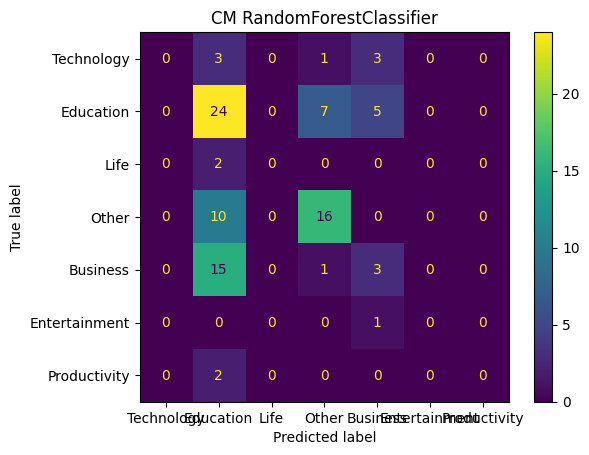

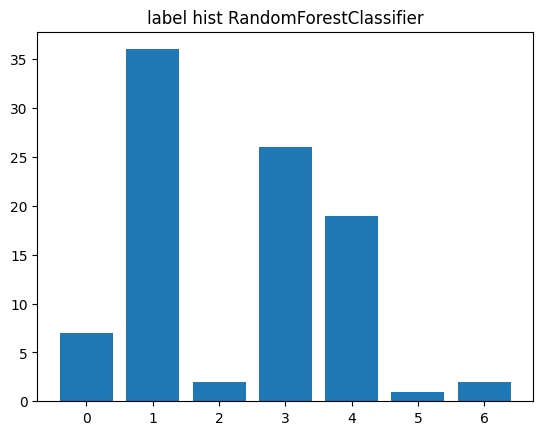

In [80]:
model_name = "RandomForestClassifier"

print("="*80 + f"\n{model_name}\n" + "="*80)

name, split = ("df_text_map_idea_max_split", df_text_map_idea_max_split)

print("-"*80 + "\n" + name + "\n" + "-"*80)
model = get_model(model_name)
pipeline = make_pipeline(StandardScaler(), model)
tic = time.time()
scores, accuracy = fit_and_print_scores(pipeline, split[0], split[2])
toc = time.time() - tic
test_acc = pipeline.score(split[1], split[3])
print(f"Accuracy test    : {test_acc:.4f}")
plot_results(pipeline, split[1], split[3], model_name)
plot_results(pipeline, split[1], split[3], model_name, save=True)

In [43]:
import pickle

with open(FITTED_CLASSIFIER_MODEL_PATH, 'wb') as f:
    pickle.dump(pipeline, f)

## Fine tune best classifier

TODO: Fine tune the models. The following code is an example of fine tuning using grid search and feature selection.

In [13]:
# # Grid search hyperparams
# print("-"*80 + "\nGrid search\n" + "-"*80)
# model = get_model("RandomForestClassifier")
# params = [{'n_estimators': [1, 50, 100, 150, 200, 250],
#            'max_depth': [1, 2, 3, 4, 5, 6, 7, 8, 9, 10]}]
# grid_search = GridSearchCV(model, param_grid=params, scoring='accuracy',
#                            cv=StratifiedKFold(n_splits=KFOLD),
#                            n_jobs=-1, verbose=0)
# accuracy, best_params = fit_and_print_scores(grid_search, X, y)

# # Grid search hyperparams with feature selection
# print("-"*80 + "\nGrid search with RFECV\n" + "-"*80)
# rfecv_estimator = get_model("RandomForestClassifier")
# rfecv = RFECV(estimator=rfecv_estimator, step=1,
#               cv=StratifiedKFold(n_splits=KFOLD),
#               scoring='accuracy', verbose=0)
# model = get_model("RandomForestClassifier")
# params = [{'n_estimators': [1, 50, 100, 150, 200, 250],
#            'max_depth': [1, 2, 3, 4, 5, 6, 7, 8, 9, 10]}]
# grid_search = GridSearchCV(model, param_grid=params, scoring='accuracy',
#                            cv=StratifiedKFold(n_splits=KFOLD),
#                            n_jobs=-1, verbose=0)
# pipeline = make_pipeline(rfecv, grid_search)
# accuracy, best_params = fit_and_print_scores(pipeline, X, y)

In [79]:
# Fine tune with manual feature selection

from contextlib import redirect_stdout
import time

summary_df = pd.DataFrame(
    columns=['experiment', 'val', 'val_cv1', 'val_cv2', 'val_cv3',
             'val_cvall', 'test', 'time']
)

with open(FT_MODEL_TRAINING_PATH, 'w') as f:

    model_name = "RandomForestClassifier"

    print(f"Processing {model_name}")

    with redirect_stdout(f):

        print("="*80 + f"\n{model_name}\n" + "="*80)

        for name, split in [
            ("df_text_map_idea_max_bert_en_split", df_text_map_idea_max_bert_en_split),  # noqa
            ("df_text_map_idea_max_bert_en_tok_split", df_text_map_idea_max_bert_en_tok_split),  # noqa
            ("df_text_map_idea_max_bert_en_emb_split", df_text_map_idea_max_bert_en_emb_split),  # noqa
            ("df_text_map_idea_max_bert_split", df_text_map_idea_max_bert_split),  # noqa
            ("df_text_map_idea_max_bert_tok_split", df_text_map_idea_max_bert_tok_split),  # noqa
            ("df_text_map_idea_max_bert_emb_split", df_text_map_idea_max_bert_emb_split),  # noqa
            ("df_text_map_idea_max_m2m_split", df_text_map_idea_max_m2m_split),  # noqa
            ("df_text_map_idea_max_m2m_tok_split", df_text_map_idea_max_m2m_tok_split),  # noqa
            ("df_text_map_idea_max_m2m_emb_split", df_text_map_idea_max_m2m_emb_split)  # noqa
        ]:
            print("-"*80 + "\n" + name + "\n" + "-"*80)
            model = get_model(model_name)
            pipeline = make_pipeline(StandardScaler(), model)
            tic = time.time()
            scores, accuracy = fit_and_print_scores(
                pipeline, split[0], split[2])
            toc = time.time() - tic
            test_acc = pipeline.score(split[1], split[3])
            print(f"Accuracy test    : {test_acc:.4f}")
            # plot_results(pipeline, split[1], split[3], model_name)
            summary_df = pd.concat(
                [pd.DataFrame([[f"{model_name}_{name}",
                                round(accuracy, 4),
                                round(scores['test_score'][0], 4),
                                round(scores['test_score'][1], 4),
                                round(scores['test_score'][2], 4),
                                round(scores['test_score'].mean(), 4),
                                round(test_acc, 4),
                                toc]],
                              columns=summary_df.columns), summary_df],
                ignore_index=True
            )

summary_df.to_csv(FT_TRAINING_SUMMARY_PATH)

print(f"Check file for results : {FT_MODEL_TRAINING_PATH}")
print(f"Check file for summary : {FT_TRAINING_SUMMARY_PATH}")

Processing RandomForestClassifier
Check file for results : ../result/ft_model_training.log
Check file for summary : ../result/ft_training_summary.csv
